Copyright 2020 Luiz Schirmer

Permission is hereby granted, free of charge, to any person obtaining a copy of this code and 
associated documentation files, to deal in the code without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, 
sublicense, and/or sell copies of the code, and to permit persons to whom the code is 
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the code.

THE CODE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT 
NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, 
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE CODE OR THE USE OR OTHER DEALINGS IN THE CODE.

__license__ = "MIT"
__author__ = "Luiz Schirmer"
__email__ = "lschirmer@inf.puc-rio.br"
__credits__ = ["Luiz Schirmer", "Guilherme Schardong", "Vinicius da Silva", "Rogério Santos","Hélio Lopes"]

In [10]:
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Multiply,Add,Lambda, MaxPooling2D,Concatenate,GlobalAveragePooling2D,Dense,Flatten,Dropout,UpSampling2D,Reshape
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import numpy as np
from skimage.filters import gaussian
from skimage import measure
from skimage import exposure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Input,LeakyReLU
from tensorflow.keras.models import Sequential, Model, model_from_json
from sklearn.feature_extraction import image
import segyio

In [11]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model('model_geo.h5')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, None, None, 2 200         input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_12 (LeakyReLU)      (None, None, None, 2 0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv1_w (Conv2D)                (None, None, None, 2 3620        leaky_re_lu_12[0][0]             
____________________________________________________________________________________________

In [12]:
import segyio
import numpy as np

with segyio.open("./F3_SEGY1", "r") as f:
    n = f.iline[690]
    print(n)
    n_traces = f.tracecount
    twt = f.samples

[[    0.     0.     0. ...  5049.  2509. -1184.]
 [    0.     0.     0. ...  5685.  3031. -1019.]
 [    0.     0.     0. ...  4961.  2627.   -96.]
 ...
 [    0.     0.     0. ...  2051.    84. -1936.]
 [    0.     0.     0. ...  2416.   -30. -2197.]
 [    0.     0.     0. ... -3226. -1661.    58.]]


In [13]:
# Gaussian smoothing with default std 1.5
# https://stackoverflow.com/a/45020378
def myGaussSmooth( data, std=1.5):
    return gaussian(data,sigma=std,truncate=2)

In [14]:
#Clipping 
def clip(data,min=-6000,max=6000):
    data[data>max] = max
    data[data<min] = min
    return data

In [15]:
# Normalizes values of a matrix between -1 and 1
def myNormalization(data):
    max_val = np.max(data)
    min_val = np.min(data)
    
    return  2 * (data[:,:] - min_val) / (max_val - min_val) - 1

<Figure size 648x288 with 0 Axes>

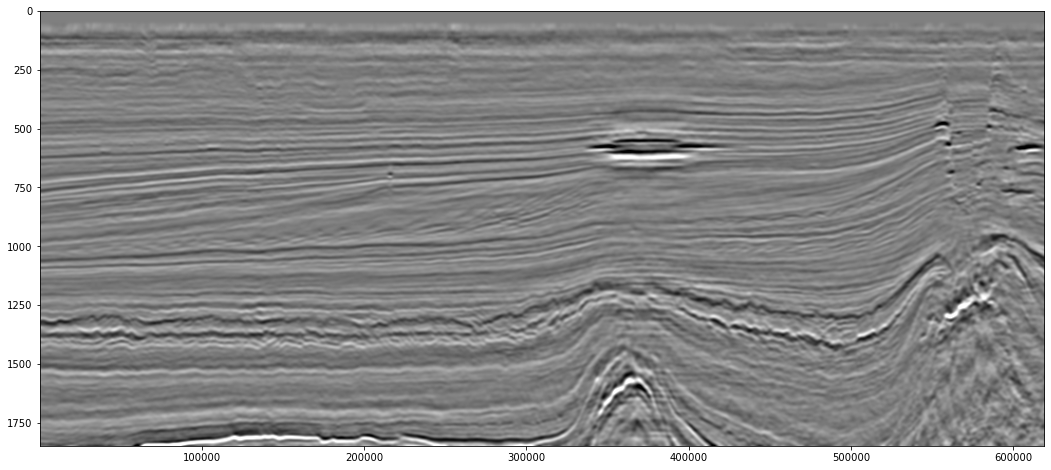

In [16]:
data = n.transpose() #f[:,:,620]
data = data*-1
data = myGaussSmooth(data)

    # Clip
data = clip(data)

    # Normalize between -1 and 1 
data = myNormalization(data)



fig = plt.figure(figsize=(9,4))
plt.figure(figsize=(18,8))

    #plt.axis('off')
plt.imshow(data, cmap="gray", aspect='auto', extent = [1, n_traces, twt[-1], twt[0]])
plt.savefig('secao_gas_690_gray.png',dpi=300)

(413808, 20, 20)
(413808, 20, 20, 1)


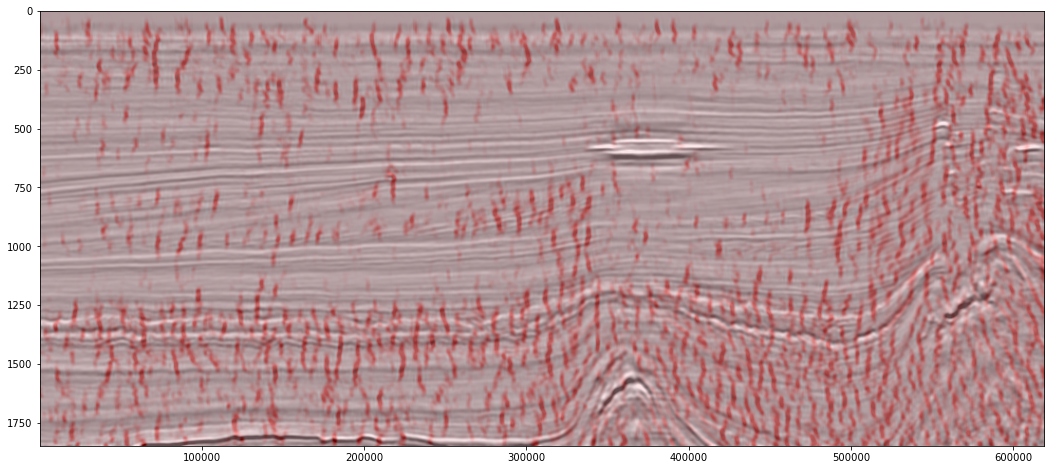

In [17]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction import image
s = data
patches_img = image.extract_patches_2d(s, (20, 20))
print(patches_img.shape)


patches = patches_img.reshape( patches_img.shape[0], 20, 20, 1)
features = model.predict(patches)
print(features.shape)
features = features.reshape(features.shape[0],20,20)
img = reconstruct_from_patches_2d(features, (s.shape[0], s.shape[1]))   

a = np.min(img)
img = 2.*(img - np.min(img))/np.ptp(img)-1


import matplotlib.colors

norm=plt.Normalize(-1,1)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["ghostwhite","red","darkred"])

fig, ax = plt.subplots(figsize=(18,8))
#plt.axis('off')
s = s*-1
ax.imshow(s, cmap="gray", aspect='auto',extent = [1, n_traces, twt[-1], twt[0]])
ax.imshow(img, cmap=cmap, norm=norm,alpha=.4, aspect='auto',extent = [1, n_traces, twt[-1], twt[0]])
plt.savefig('secao_gas_690_rogerio.png',dpi=300)